# Image Compression Engine using JPEG algorithm

In [1]:
# Imports
import numpy as np 
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import os
from huffman import *
import pickle
import csv

In [2]:
def read_image(path_to_image):
    """
    Reads a grayscale image from the specified path and returns an array of pixel intensities
    """
    if not os.path.exists(path_to_image):
          raise FileNotFoundError(f"N   mage found at the specified path: {path_to_image}")
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    return image

In [3]:
def DCT_2D(input_block):
    """
    Takes as parameter 2D numpy array of the given block of image and returns the normalized 2D DCT coefficients using scipy's DCT implementation.
    """
    row, col = input_block.shape
    # For a 2D DCT, we first compute the DCT along one dimension (rows: axis = 0), then apply it along the other dimension (columns, axis = 1) 
    # followed by orthogonal normalization (`norm='ortho'`) to ensure perfect reconstruction during inverse DCT.
    dct_coeff = dct(dct(input_block, axis=0, norm='ortho'), axis=1, norm='ortho')
    
    return dct_coeff

def IDCT_2D(input_block):
    """
    Takes as parameter a 2D numpy array of DCT coefficients and returns the 2D IDCT transform using scipy's IDCT implementation.
    """
    # For a 2D IDCT, we first compute the IDCT along one dimension (rows: axis = 0), then apply it along the other dimension (columns, axis = 1) 
    # followed by orthogonal normalization (`norm='ortho'`) to ensure perfect reconstruction.
    inverted = idct(idct(input_block, axis=0, norm='ortho'), axis=1, norm='ortho')

    return inverted

In [4]:
def get_zigzag_indices(size = 8):
    """
    Takes as parameter the size of the square matrix and returns the indices of the elements in zigzag order
    """
    indices = []

    # Loops through all possible diagonals in a size x size matrix
    # The number of diagonals in a square matrix is 2 * size - 1
    for diag in range(2 * size - 1):
        i_min = max(0, diag - size + 1)  # Start index for the diagonal
        i_max = i_min + min(diag, 2 * (size - 1) - diag)  # End index for the diagonal
        # Traverse the elements along the current diagonal
        for i in range(i_min, i_max + 1):
            if diag % 2 == 0:  # For even diagonals, zigzag from top-right to bottom-left
                row, col = diag - i, i
            else:  # For odd diagonals, zigzag from bottom-left to top-right
                row, col = i, diag - i
            indices.append((row, col))
    return indices


In [5]:
def get_quantization_matrix(Q):
    """
    Takes as a parameter the quality factor Q and returns the quantization matrix.
    """
    # Default JPEG quantization matrix for Q = 50
    default_matrix = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    # Determine scaling factor S based on the quality factor Q
    if Q < 50:
        S = 5000 / Q  # For lower quality factors, scaling is higher
    else:
        S = 200 - 2 * Q  # For higher quality factors, scaling is lower

    scaled_matrix = ((S * default_matrix) + 50) // 100
    scaled_matrix[scaled_matrix == 0] = 1  # To division-by-zero errors, ensure non-zero matrix entries

    return scaled_matrix


def quantize(dct_block, Q):
    """
    Takes as parameters the block of DCT coefficients and quality factor and 
    quantizes the DCT coefficients by dividing elementwise by the quantization matrix.
    """
    quantization_matrix = get_quantization_matrix(Q)
    # Elementwise quantization by dividing by the quantization matrix
    return np.round(dct_block / quantization_matrix).astype(int)


In [6]:
def encode_runlength(array):
    '''Takes as parameter an array of elements and returns the encoded array using runlength encoding on "0" because it is the most occuring element 
    '''
    encoded = []
    counter = 0
    for element in array:
        if (element == 0):                          
            counter += 1    #if element is zero, increment counter
        else:                                       
            if (counter != 0):   # check if we were in a zero sequence
                encoded.extend([0, counter]) # zero sequence interrupted
                counter = 0  # reset counter
            encoded.append(element)   # add the non zero element to the array 
            
    if counter != 0:  # handling trailing zeros
        encoded.extend([0, counter])
    return encoded

In [7]:
def decode_runlength(array):
    '''Takes a runlength encoded sequences and returns the decoded array
    '''
    decoded = []
    index = 0
    while index < len(array):
        if array[index] == 0:                
            count = array[index+1]        # element after 0 is the count of consecutive zeros
            zero_seq = [0]*count          # recreate the zero sequence
            decoded.extend(zero_seq)      # append the zero sequence
            index+=2                      # update the index by 2 to bypass the count
        else:                               
            decoded.append(array[index])
            index += 1
    return np.array(decoded)

In [8]:
def pad_image(image):
    """
    Takes as argument an image and pads it to make its dimensions multiples of 8
    """
    rows, cols = image.shape
    rows_padded = rows
    cols_padded = cols
    if (rows % 8 != 0):
        rows_padded = rows + (8 - rows % 8)
    if (cols % 8 != 0):
        cols_padded = cols + (8 - cols % 8)
    
    if (rows_padded, cols_padded) == image.shape:
        return image
    padded_image = np.zeros((rows_padded, cols_padded))    
    padded_image[0:rows, 0:cols] = image # pad zeros at the end of rows and columns of original image
    return padded_image

In [9]:
def create_blocks(image, block_size = 8):
    """
    Takes as argument an image array and returns a list of 8x8 blocks of the image
    """
    padded_image = pad_image(image)
    blocks = []
    row, col = padded_image.shape
    n_block_row = int(row/block_size)
    n_block_col = int(col/block_size)
    
    for i in range(n_block_row):
        for j in range(n_block_col):
            current_block = padded_image[i*block_size: (i+1)*block_size, j*block_size: (j+1)*block_size]
            blocks.append(current_block)
    return blocks, padded_image.shape

In [10]:
def encode_JPEG(image, Q = 50):
    """
    Takes as arguments an image array and quality factor and returns the Huffman encoded stream of bits
    along with the Huffman dictionary, and the size of the padded image
    """  
    blocks, padded_shape = create_blocks(image, 8) # Divides the image into patches of size 8 x 8
    
    zigzag_indices = get_zigzag_indices(8)  # get the sequence of indices following zig-zag unrolling
    zig_zag_row, zig_zag_col = zip(* zigzag_indices)
    
    stream = []
    for block in blocks:
        dct_coeff_block = DCT_2D(block)  # Get the dct coefficients of the current block
        q_block = quantize(dct_coeff_block, Q)  # Perform quantization
        q_block = np.round(q_block).astype(int)  # Ensure coefficients are integers
        ordered_block = q_block[zig_zag_row, zig_zag_col]  # Use zigzag unrolling to form a sequence
        rn_vector = encode_runlength(ordered_block)  # Apply Runlength encoding on the sequence
        stream.extend(rn_vector)  # Append it to get a single sequence for all blocks

    # Create the Huffman table based on the stream
    huffman_tree = generate_huffman_tree(stream)
    huffman_dict = huffman_tree.traverse()
    huffman_stream = encode_huffman(stream, huffman_dict)
    return huffman_stream, huffman_dict, padded_shape
    

In [11]:
def decode_JPEG(hf_stream, huffman_dict, original_dims, Q=50):
    """
    Takes as argument a JPEG-compressed image stream, Huffman dictionary used for encoding and the dimension of original image
    and reconstructs the original image.
    """
    # Calculate padded dimensions (nearest multiple of 8)
    padded_height = (original_dims[0] + 7) // 8 * 8
    padded_width = (original_dims[1] + 7) // 8 * 8

    zigzag_indices = get_zigzag_indices(8)  # Get the sequence of indices following zig-zag unrolling
    zigzag_row, zigzag_col = zip(*zigzag_indices)

    # Create the image with padded dimensions
    reconstructed_image = np.empty((padded_height, padded_width))
    no_of_blocks = (padded_width // 8) * (padded_height // 8)  # Total number of blocks

    # Decode the Huffman encoded stream to obtain the run-length encoded stream
    dec_hf_stream = decode_huffman(hf_stream, huffman_dict)
    dec_rn_stream = decode_runlength(dec_hf_stream)

    # Determine the number of 64-element chunks in the decoded run-length stream
    no_of_chunks = len(dec_rn_stream) // 64

    # Process each chunk (which corresponds to a block of size 8x8)
    for i in range(no_of_chunks):
        chunk = dec_rn_stream[i * 64: (i + 1) * 64]  # Extract the current 64-element chunk

        dct_coeff = np.empty((8, 8))
        # Fill the empty block with the decoded values, using the zigzag order for placement
        dct_coeff[zigzag_row, zigzag_col] = chunk

        # Multiply the quantized coefficients by the quantization table to restore the original scale
        q_table = get_quantization_matrix(Q)
        dct_coeff = dct_coeff * q_table

        # Calculate the position of the current block in the full image
        row_index = int(i / (padded_width // 8))  
        col_index = i % (padded_width // 8)

        # Insert the block into the reconstructed image
        reconstructed_image[row_index * 8: (row_index + 1) * 8, col_index * 8: (col_index + 1) * 8] = IDCT_2D(dct_coeff)

    # Slice the reconstructed image to match the original dimensions
    reconstructed_image = reconstructed_image[:original_dims[0], :original_dims[1]]
    
    return reconstructed_image


In [12]:
def calculate_relative_rmse(original, reconstructed):
    """
    Takes as argument the original image array and the reconstructed image array and calculates the relative Root Mean Square Error between them
    """
    rmse = np.sqrt(np.mean((original - reconstructed) ** 2))
    relative_rmse = rmse / np.sqrt(np.sum(original ** 2))
    return relative_rmse

def calculate_bpp(compressed_image_path, image_shape):
    """
    Takes as argument the path of .bin of compressed image and shape of original image and calculate Bits Per Pixel (BPP)
    """
    file_size = os.path.getsize(compressed_image_path) * 8  # File size in bits
    total_pixels = image_shape[0] * image_shape[1]
    return file_size / total_pixels

In [13]:
def jpeg_compress(image_path, Q, compressed_file):
    """
    Takes as argument the path to original image, quality factor and the path to a .bin file 
    and compress the image using a JPEG and saves it to a .bin file
    """
    # Load the image
    original = read_image(image_path)

    # Get the image name without the file extension
    image_name = os.path.basename(image_path).split('.')[0]

    # Create the output directory if it doesn't exist
    compressed_folder = "compressed"
    os.makedirs(compressed_folder, exist_ok=True)

    # Compress the image
    huffman_stream, huffman_dict, padded_shape = encode_JPEG(original, Q)

    # Save compressed data to a .bin file
    compressed_data = {
        "huffman_stream": huffman_stream,  # Huffman-encoded bitstream
        "huffman_dict": huffman_dict,      # Huffman dictionary
        "original_dims": original.shape    # shape of the original image
    }
    
    with open(compressed_file, "wb") as f:
        pickle.dump(compressed_data, f)

In [14]:
def jpeg_decompress(comp_path, Q):
    """
    Takes as argument the path to the .bin of compressed image and quality factor and returns the decompressed image 
    """
    # Load the compressed data
    with open(comp_path, "rb") as f:
        compressed_data = pickle.load(f)

    # Extract Huffman stream, Huffman dictionary, and original image dimensions
    huffman_stream = compressed_data["huffman_stream"]
    huffman_dict = compressed_data["huffman_dict"]
    original_shape = compressed_data["original_dims"]

    # Decode the huffman stream and reconstruct the image
    decompressed_image = decode_JPEG(huffman_stream, huffman_dict, original_shape, Q)

    # Clip the values to valid image range
    decompressed_image = (np.clip(decompressed_image, 0, 255)).astype(np.uint8)
    return decompressed_image

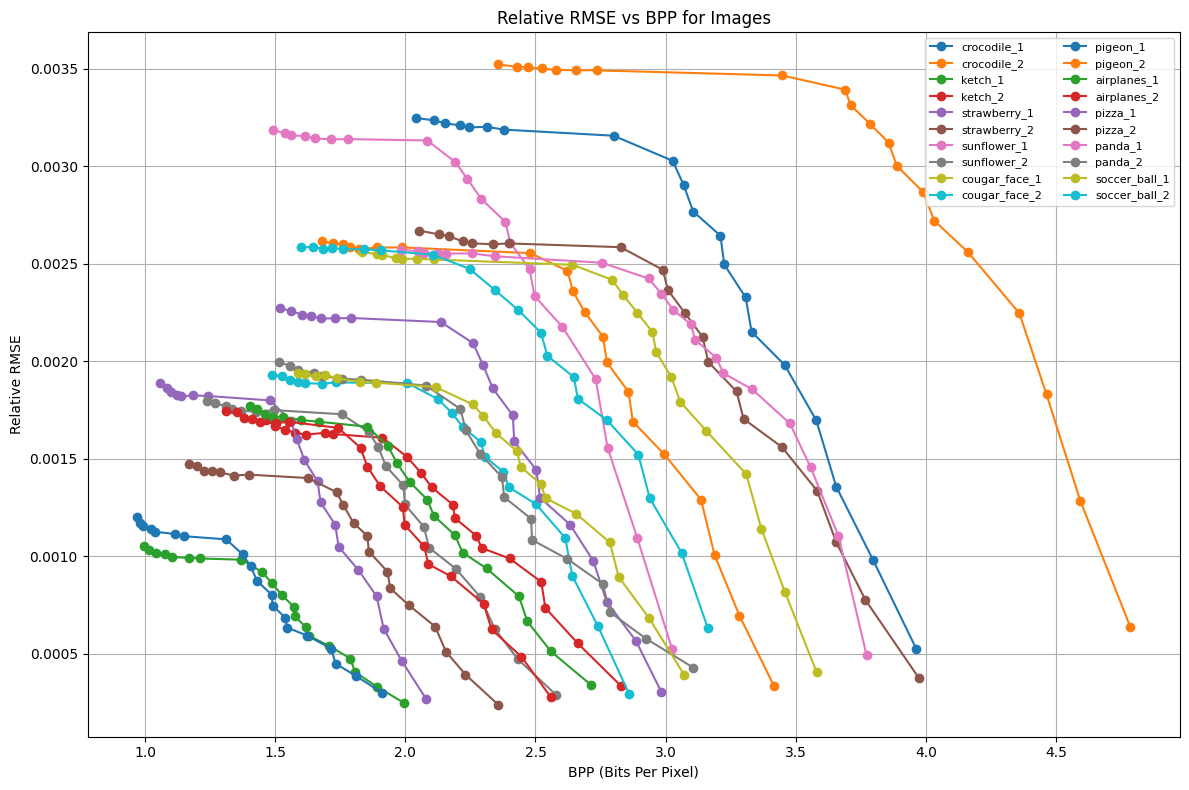

In [56]:
def process_images(dataset_path, compressed_folder, quality_factors, images_result):
    """
    Process images from the dataset, compresses them according to the list of quality factors given and saves in compressed_folder
    Decompress them, and calculate RMSE and BPP and save in results folder
    """
    results = []

    # Loop through the subfolders folders
    categories = os.listdir(dataset_path)
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue

        # Get images 10 and 20 (0-based index)
        images = sorted(os.listdir(category_path))
        selected_images = [images[9], images[19]]
        idx = 1
        for img_name in selected_images:
            img_path = os.path.join(category_path, img_name)
            original = read_image(img_path) 

            for Q in quality_factors:  # Loop over the quality factors
                # Create compressed file path
                compressed_file = os.path.join(compressed_folder, f"{category}_{img_name}_Q{Q}.bin") 
                # Compress the image and save to .bin file
                jpeg_compress(img_path, Q, compressed_file)
                # Decompress the image
                decompressed_image = jpeg_decompress(compressed_file, Q)
                
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(original, cmap='gray')
                axes[0].set_title("Original Image")
                axes[0].axis('off')
                axes[1].imshow(decompressed_image, cmap='gray')
                axes[1].set_title(f"Compressed (Q={Q})")
                axes[1].axis('off')

                # Save the figure
                output_file = os.path.join(images_result, f"{category}_{img_name}_Q{Q}.png")
                plt.savefig(output_file)
                plt.close(fig)

                # Calculate metrics: RMSE and BPP
                rmse = calculate_relative_rmse(original, decompressed_image)
                bpp = calculate_bpp(compressed_file, original.shape[:2])

                # Store results
                results.append((rmse, bpp, Q, img_name, category, idx))

                # Save RMSE and BPP values to a CSV file
                with open(results_folder, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([category, img_name, Q, rmse, bpp])
            idx += 1
    return results

def plot_results(results):
    """
    Plot RMSE vs. BPP for all selected images and quality factors
    """
    plt.figure(figsize=(12, 8))
    grouped_results = {}
    for r in results:
        category = r[4]
        idx = r[5]
        key = f"{category}_{idx}"
        if key not in grouped_results:
            grouped_results[key] = {"bpp": [], "rmse": []}
        grouped_results[key]["bpp"].append(r[1])  # Append BPP
        grouped_results[key]["rmse"].append(r[0])  # Append RMSE

    # Plot RMSE vs BPP for each image
    for key, data in grouped_results.items():
        plt.plot(data["bpp"], data["rmse"], marker='o', label=key)

    plt.xlabel("BPP (Bits Per Pixel)")
    plt.ylabel("Relative RMSE")
    plt.title("Relative RMSE vs BPP for Images")
    plt.legend(fontsize=8, loc='best', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

dataset_path = "101_ObjectCategories"  # Path to the dataset
compressed_folder = "compressed"  # Folder to save .bin files
images_result = "images_result"
os.makedirs(compressed_folder, exist_ok=True)  # Create the folder if it doesn't exist
results_folder = "results.csv"  # Path to save RMSE and BPP results
quality_factors = list(range(36, 75, 2))  # Quality factors from 36 to 74 with a step of 2

with open(results_folder, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Category", "Image", "Quality", "RMSE", "BPP"])

# Run the processing
results = process_images(dataset_path, compressed_folder, quality_factors, images_result)

# Plot the results
plot_results(results)


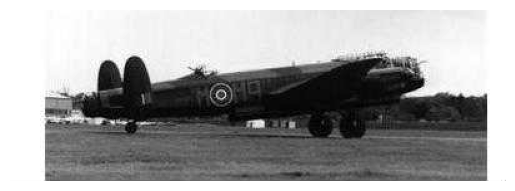

In [95]:
img = jpeg_decompress("compressed/airplanes_image_0010.jpg_Q50.bin", 50)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()